# Deep Learning for NLP - Exercise 03
In this exercise, we will be using the Hugging Face ecosystem to finetune BERT for a classification task (part 1) and T5 for text summarization (part 2). Then, we will upload our training and validation results via TensorBoard, which makes interactive sharing and inspecting of results very easy.

Part 1 and part 2 can be worked on independently.

___
General hints:
* Have a look at the imports below when solving the tasks
* Use the given modules and all submodules of the imports, but don't import anything else!
    * For instance, you can use other functions under the `torch` or `nn` namespace, but don't import e.g. PyTorch Lightning, etc.
* It is recommended to install all packages from the provided environment file
* Feel free to test your code between sub-tasks of the exercise sheet, so that you can spot mistakes early (wrong shapes, impossible numbers, NaNs, ...)
* Just keep in mind that your final submission should be compliant to the provided initial format of this file

Submission guidelines:
* Make sure that the code runs on package versions from the the provided environment file
* Do not add or change any imports (also don't change the naming of imports, e.g. `torch.nn.functional as f`)
* Remove your personal, additional code testings and experiments throughout the notebook
* Do not change the class, function or naming structure as we will run tests on the given names
* Additionally export this notebook as a `.py` file, and submit **both** the executed `.ipynb` notebook with plots in it **and** the `.py` file
* **Deviation from the above guidelines will result in partial or full loss of points**

In [1]:
# !pip install transformers==4.24.0
# !pip install datasets==3.0.1
# !pip install evaluate==0.4.0
# !pip install rouge-score==0.1.2
# !pip install py7zr

  Using cached transformers-4.24.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.7.0 requires transformers<5.0.0,>=4.34.0, but you have transformers 4.24.0 which is incompatible.


# Task 1: Sequence Classification with BERT

* In this task, we will finetune [BERT](https://huggingface.co/bert-base-uncased) on a custom sentiment classification dataset and perform multi-class sequence classification.

In [1]:
import os
import random
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datasets import load_dataset

from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
os.environ['TOKENIZERS_PARALLELISM'] = 'false' 

We start by downloading the [DAIR-AI Emotion Dataset](https://huggingface.co/datasets/dair-ai/emotion) from the Hugging Face Hub, which already comes with a train, validation, and test split of 16,000 - 2,000 - 2,000 samples. The dataset consists of tweets with their labeled emotions over 6 different classes.

* As the dataset, by default, consists of integer labels, we first create two helper dictionaries
    * `idx2lbl`, which maps the integer index to the label string
    * `lbl2idx`, which maps the label strings to the integer index
    * The downloaded Hugging Face dataset object implements a useful `.features` method for each dataset split, which contains the label strings in the correct order corresponding to the integers (the labels are consistent across each split, so it is enough to only inspect one split)
* Try to get an overview of the data and the dataset format by printing 10 random (use the `random` library to sample random numbers!) samples of the train split with their corresponding integer and string labels

In [3]:
emotion_dataset = load_dataset("dair-ai/emotion")

In [4]:
label_features = emotion_dataset['train'].features['label']
idx2lbl = {i: label for i, label in enumerate(label_features.names)}
lbl2idx = {label: i for i, label in enumerate(label_features.names)}

In [5]:
rand_idxs = random.sample(range(len(emotion_dataset['train'])), 10)
for idx in rand_idxs:
    example = emotion_dataset['train'][idx]
    print(f"Text: {example['text']}, Label: {idx2lbl[example['label']]}")

Text: i did sleep last night however but woke up at am feeling splendid other than sniffles and itchy throat and just wasnt sure how i could be so awake, Label: joy
Text: out on a weekend with a group of people, Label: anger
Text: i feel rejected by someone then what part of myself am i rejecting, Label: sadness
Text: i feel like if i had a job worth caring about i wouldn t be so shifty, Label: love
Text: im feeling dull and bored, Label: sadness
Text: i couldn t feel positive emotions of any sort, Label: joy
Text: i feel quite lucky to have stumbled upon it, Label: joy
Text: i asked feeling hesitant, Label: fear
Text: i feel fantastic and i find that i have a renewed sense of strength and endurance, Label: joy
Text: on a dark night i felt that there were several people near me and i did not know who they were, Label: fear


To start the preprocessing steps, we first need to load the pre-trained tokenizer for our [bert-base-uncased](https://huggingface.co/bert-base-uncased) model, which can be achieved very comfortable using the `AutoTokenizer` [class API](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) from Hugging Face.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

If we enter an example input from the train set into the tokenizer, we can see that we receive again dictionaries as output, which is the preferred data format from Hugging Face.

In [7]:
example_text = emotion_dataset['train'][0]['text']
example_seq = tokenizer(example_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

print("Original Text:", example_text)
print("Tokenized Output:", example_seq)

Original Text: i didnt feel humiliated
Tokenized Output: {'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

* We can see that the dictionary contains `input_ids`, which represent the tokenized sequence *including* specials tokens
    * For instance, notice that the sequence begins with `101`, which is used by BERT to mark the `[CLS]` token
    * The sequence ends with the `102` token, which BERT uses as a separation mark between sequences, `[SEP]`
    * You can check all special tokens using `tokenizer.all_special_tokens` and `tokenizer.all_special_ids`
* Secondly, the tokenizer contains `token_type_ids`, which are used to distinguish different segments of input tokens in models that support token-level type embeddings, like BERT and its variants
    * These embeddings are useful for tasks like sentence pair classification or question answering, where the model needs to understand which tokens belong to which part of the input. (not needed here)
* Thirdly, the tokenizer automatically creates the attention mask, which consists of all `1` in this case
    * The attention mask in input sequences is usually only `0` when padding symbols are added, as we don't want to attend to padding symbols

Following this, we can use the tokenizer to tokenize our entire dataset.

* Hugging Face dataset objects provide a way to `map` a function onto every single object using powerful parallel processing operations
* There, we need to create a function which acts like it:
    * takes in text examples of a data split of our dataset object
    * inputs it into the tokenizer
        * use the tokenizer with options `truncation=True` and `max_length=512`, since the maximum context size of BERT is 512 tokens
        * This shouldn't impact our dataset in any way since the Tweet dataset stems from the times when tweets were limited to 280 characters, but it's better to be safe than sorry and have your training interrupted
    * return the output of the tokenizer
* Apply the function onto the entire dataset object using its `map` method with the option `batched=True`

In [8]:
def tokenize_seqs(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512, padding="max_length")

tokenized_datasets = emotion_dataset.map(tokenize_seqs, batched=True)

* Lastly, the [Hugging Face Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) expects the class labels to be named `labels`, so we need to rename the label column from `label` to `labels`
    * Make use of the provided functions in the [Hugging Face Datasets API](https://huggingface.co/docs/datasets/process)

In [9]:
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
#print(tokenized_datasets['train'][0])

{'text': 'i didnt feel humiliated', 'labels': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

* We can now load our pre-trained BERT model [bert-base-uncased](https://huggingface.co/bert-base-uncased) from the Hugging Face Hub
    * Use the `AutoModelForSequenceClassification`, see [here](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSequenceClassification)
    * Specifically, use the `from_pretrained` [method](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSequenceClassification.from_pretrained) and provide the number of labels, and the `id2lbl` and `lblidx` functions we created earlier
    * This will configure a `PretrainedConfig` object, which will behave differently depending on whether we train or fine-tune. Have a look [here](https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/configuration#transformers.PretrainedConfig)

In [10]:
num_labels = len(idx2lbl)  
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label=idx2lbl,
    label2id=lbl2idx
)
# print(model.config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Next, we are going to define a function that calculates our desired training objective, in our case, the F1 score. In typical Hugging Face fashion, it needs to return a dictionary
* First, the function will be called `compute_metrics`
    * In theory, it could be any name, but should include *all* metrics you want the return from training, each with its key-value pair in the dictionary
    * The key should always represent the name of the metric, and the value should be the calculated metric  
* Secondly, it will take a `eval_preds` parameter
    * This is an intermediate result type output from the Hugging Face `Trainer` object
    * It is a `NamedTuple` of type [EvalPred](https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/configuration#transformers.PretrainedConfig), which holds our predictions and label ids
    * You can access them using the `eval_preds.label_ids`, and `eval_preds.predictions` methods
* Extract the predictions and labels
* Find the predicted class index using `argmax()` with the correct dimension parameter
* Calculate the F1 score using the previously imported sklearn function
    * Since we have a multi-class classification problem, use the `average='weighted'` choice
    * Other settings can also make sense, but in this case, we use the `'weighted'` option
* Return a dictionary in the style `{'f1': f1}`

In [11]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds.predictions, eval_preds.label_ids
    preds = logits.argmax(axis=-1) 
    f1 = f1_score(labels, preds, average='weighted')
    return {"f1": f1}

Finally, we are putting it all together in a [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) instance. It has *a lot* of options, so go and have a look at the above link to the documentation.

In our case, we will set the following:
* [output_dir](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.output_dir), the directory where you want to save model checkpoints and logging files
    * Use something like `'./logs/run1'`, because we will later run more experiments, which should then be named `'./logs/run2/'`, so that everything is contained in one directory
* [per_device_train_batch_size](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.per_device_train_batch_size), the batch size used for training
    * since we need to store all ~110mio. parameters of BERT, the gradient for all parameters, and one tokenized batch on the GPU, this will be a rather small batch size of e.g. 4 or 8 (see below for some tricks we can use to artifically increase the effective training batch size)
* [per_device_eval_batch_size](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.per_device_eval_batch_size), the batch size used for evaluation
    * can be approximately 4x the training batch size
* [gradient_accumulation_steps](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.gradient_accumulation_steps), adds up the gradients of multiple batches in order to artificially increase the batch size while keeping GPU memory lower
    * set it to 2, which approximates training with double our train batch size
    * see [here](https://huggingface.co/docs/transformers/v4.18.0/en/performance) and [here](https://huggingface.co/docs/transformers/perf_train_gpu_one) for more memory and training speed tricks
* [learning_rate](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.learning_rate), the learning rate for [AdamW](https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/optimizer_schedules#transformers.AdamW) optimizier, a popular choice for pure transformer model training and fine-tuning
    * set it to `2e-5`, transformers generally use much lower training rates than LSTMs or CNNs
* [weight_decay](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.weight_decay), weight decay rate used for regularization
    * set it to `1e-3`
* [num_train_epochs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.num_train_epochs(float,), the number of epochs to train
    * set it to 3
* [evaluation_strategy](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.evaluation_strategy), in which intervals evaluation on the dev set should be performed
    * set to `'epoch'`
* [logging_strategy](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.logging_strategy), at which point during training logging should take place, e.g. at every $N$ steps, or per each epoch
    * set it to `'steps'`, which requires us to set the `logging_steps` parameter
* [logging_steps](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.logging_steps), after how many optimizer steps we should log the loss
    * set it to `len(emotion_dataset['train']) / per_device_train_batch_size`
* [save_strategy](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.save_strategy), when a model checkpoint should be save
    * set it to `'epoch'`
* [save_total_limit](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.save_total_limit), how many checkpoints should be saved
    * set it to 1 to save save disk sapce
* [seed](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.seed), the random seed for model initialization, which is important for experimental reproducibilty
    * set it to 42 (it already is, by default, but just to be specific)
* [data_seed](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.data_seed), the random seed for data loading, also important for experimental reproducibility
    * set it also to 42
* [fp16](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.fp16), whether 16bit floating points should be used for training. This is another trick so save memory (roughly half of memory is used, because the default is 32bit floating points, see the two links above)
    * set it to `True`
* [dataloader_num_workers](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.dataloader_num_workers), how many workers to use for dataloading
    * set it to 2
* [load_best_model_at_end](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.load_best_model_at_end), allows us to automatically keep the best model (according to loss) in addition to the last saved, and load it after training for further prediction on the test set
    * Set it to `True`

In [32]:
training_args = TrainingArguments(
    output_dir='./logs/run1/',  
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,  
    gradient_accumulation_steps=2,  
    learning_rate=2e-5,  
    weight_decay=1e-3,  
    num_train_epochs=3,  
    evaluation_strategy='epoch',  
    logging_strategy='steps',  
    logging_steps=len(tokenized_datasets['train']) // 8,  
    save_strategy='epoch', 
    save_total_limit=1,  
    seed=42,  
    data_seed=42,  
    fp16=True,  
    dataloader_num_workers=2,  
    load_best_model_at_end=True,  
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


* Then, we just instantiate the `Trainer`, feed all arguments (`model`, `training_args`, `compute_metrics`, `train_dataset`, `eval_dataset`, `tokenizer`) into [it](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer), and start training

In [33]:
trainer = Trainer(
    model=model,  
    args=training_args,  
    train_dataset=tokenized_datasets["train"],  
    eval_dataset=tokenized_datasets["validation"],  
    tokenizer=tokenizer, 
    compute_metrics=compute_metrics  
)

In [34]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
C:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 3000
  Number of trainable parameters = 109486854


Epoch,Training Loss,Validation Loss,F1
1,No log,0.214456,0.929971
2,0.300300,0.159212,0.938308
3,0.300300,0.168792,0.940167


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to ./logs/run1/checkpoint-1000
Configuration saved in ./logs/run1/checkpoint-1000\config.json
Model weights saved in ./logs/run1/checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ./logs/run1/checkpoint-1000\tokenizer_config.json
Special tokens file saved in ./logs/run1/checkpoint-1000\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size

TrainOutput(global_step=3000, training_loss=0.23096639506022135, metrics={'train_runtime': 48702.2196, 'train_samples_per_second': 0.986, 'train_steps_per_second': 0.062, 'total_flos': 1.2629784231936e+16, 'train_loss': 0.23096639506022135, 'epoch': 3.0})

* As we specified in the `Trainer` class, we have already loaded the best model again (independent of whether it was last epoch's model or not).
* We can now run one final epoch on the test set using `trainer.predict()`, which [returns](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.predict) us a `PredictionOutput` containing, among others, the test F1 score
* Print the test F1 score and comment on the test set performance compared to the intermediate training evaluations

In [35]:
test_predictions = trainer.predict(tokenized_datasets["test"])
print("Test F1 Score:", test_predictions.metrics["test_f1"])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 8


Test F1 Score: 0.9270599185507037


___
Student answers here:

The F1 score (0.9270) on the test set shows that the model performs very well on the target task (multi-classification problem).
This shows that the model is able to distinguish between different sentiment categories very well.
___

However, we can go one step further in analyzing the model performances.

* Start by creating a plot which shows the percentages of correct and incorrect class predictions per label
* For example, you could extract the predicted classes and labels from the test predictions object, and plot a stacked bar chart with a sum that always equals 100%, and each part of the stack is made up of the percentages of correct and incorrect labels
* You are also free to use other visualization techniques that show the same kind of information as long as it is clearly visible

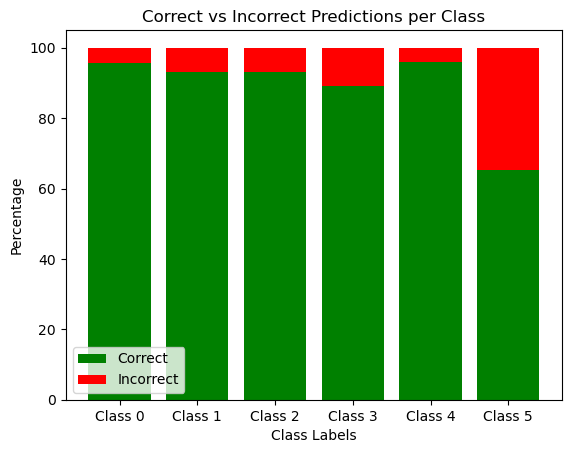

In [36]:
predictions = np.argmax(test_predictions.predictions, axis=1)  
true_labels = test_predictions.label_ids 

num_classes = len(np.unique(true_labels))
correct_counts = np.zeros(num_classes)
incorrect_counts = np.zeros(num_classes)

for i in range(len(true_labels)):
    if predictions[i] == true_labels[i]:
        correct_counts[true_labels[i]] += 1
    else:
        incorrect_counts[true_labels[i]] += 1

total_counts = correct_counts + incorrect_counts
correct_percentages = correct_counts / total_counts * 100
incorrect_percentages = incorrect_counts / total_counts * 100

labels = [f"Class {i}" for i in range(num_classes)]
x = np.arange(num_classes)

plt.bar(x, correct_percentages, label="Correct", color="green")
plt.bar(x, incorrect_percentages, bottom=correct_percentages, label="Incorrect", color="red")

plt.xlabel("Class Labels")
plt.ylabel("Percentage")
plt.title("Correct vs Incorrect Predictions per Class")
plt.xticks(x, labels)
plt.legend()
plt.show()

* What can we see from this? Briefly explain the problem.

___
Student answers here:

The proportion of correct predictions for most categories (such as Class 0, Class 1, Class 2, Class 3, Class 4) is very high (nearly 100%), indicating that the model performs relatively well on these categories.
The error rate for Class 5 (in red) is significantly higher than the other classes, indicating that the model performs worse on this class.
___

* To investigate possible reasons for this imbalance, let's look at our dataset
* Plot the train set class distribution as normalized percentages
    * You can make use of the Hugging Face datasets object's `to_pandas()` method
    * Then you can use all available data plotting and data handling techniques

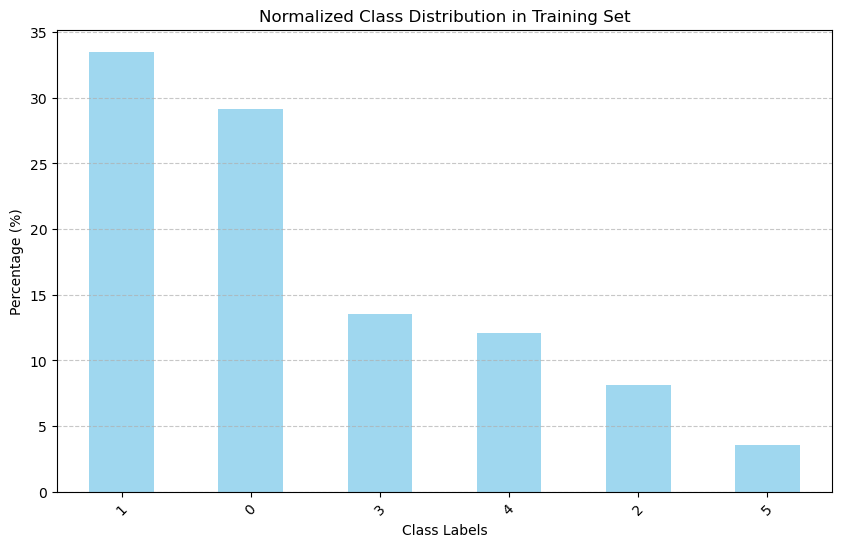

In [14]:
train_df = tokenized_datasets["train"].to_pandas()

label_counts = train_df["labels"].value_counts()
label_percentages = (label_counts / label_counts.sum()) * 100

plt.figure(figsize=(10, 6))
label_percentages.plot(kind="bar", color="skyblue", alpha=0.8)

plt.xlabel("Class Labels")
plt.ylabel("Percentage (%)")
plt.title("Normalized Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

1) What problems can you imagine when seeing this class distribution?
2) What problems could arise if we simply duplicated samples of the classes with fewer available samples?
3) What problems could arise if we simply downsampled the majority classes to the number of minority samples?

___
Student answers here:

1) the class distribution is extremely uneven. The proportion of Class 5 samples is significantly lower than that of other categories, while Class 0 and Class 1 samples account for the highest proportions. This imbalance can lead to the following problems

2) Overfitting to minority classes: Since replicated samples are repetitive in nature, the model may overfit to these samples, resulting in decreased generalization ability for minority classes.
Reduced training efficiency: Oversampling increases the size of the dataset, thereby increasing training time and memory requirements.
Not addressing data bias: Replicating samples cannot change the bias of the original data, and the feature space of minority classes is still limited, which may make it difficult for the model to learn meaningful features.

3) Information loss: Reducing the majority class samples will lead to the loss of important information and reduce the model's ability to learn the characteristics of these categories.
Insufficient sample problem: For the downsampled dataset, the overall number of samples is reduced, which may lead to underfitting of the model, especially in complex tasks.
The size of the aligned minority class is still insufficient: Even if the majority class is downsampled, the number of samples of the minority class may still be insufficient to capture its complexity characteristics.
___

How to deal with this class imbalance?

* We can modify the loss function to assign weight coefficients to the losses of certain classes
* Therefore, a wrong classification of a certain class is weighted higher or lower, depending on its coefficients we provided
* How do we calculate these weights?
    * We can make use of the existing normalized frequency distribution we plotted above
    * But calculate the element-wise complement per label, i.e. `1 - probability`, so that each resulting label represents a weight between 0 and 1 for its own class
    * You can check your calculation by adding element-wise the initial normalized label distribution to your weights, you should receive an array of 6 `1`s (ignoring floating point imprecisions)
    * Transform the type to a `torch.float32` tensor, and move the tensor separately to the `device` you want
        * Huggingface will use a GPU as soon as it finds one available, but this separate tensor needs to be moved manually
* However, since the Hugging Face Trainer we used before abstracted away the option to define our loss function, we need to overwrite the `compute_loss` (see [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.compute_loss)) function of the Trainer
* To accomplish that:
    *  we inherint from the `Trainer` class
    *  define a `compute_loss` function that takes in a `model`, `inputs`, and a `return_outputs=False` keyword
    *  First, we calculate the model `outputs` by giving our model the `inputs`
        *  our `inputs` consist of a collated batch of inputs that the tokenizer creates, along with a `'labels'`, all inside a dictionary
        *  therefore, we need to use dictionary expansion to assign all keyword arguments in the `model`
    *  the `outputs` from Hugging Face transformers, again, are a dictionary, so we need to extract their `'logits'` and assign them to a `logits` variable
    *  then, we extract the `labels` from the input
    *  create a `criterion` using our well known `nn.CrossEntropyLoss()`
        *  inside `nn.CrossEntropyLoss()`, we now use the `weight` argument and assign our calculated weight coefficients to it
    *  compute the loss
    *  return `(loss, outputs) if return_outputs else loss`

In [15]:
total_samples = label_counts.sum()
class_frequencies = label_counts / total_samples

complement_weights = 1.0 - class_frequencies

complement_weights = torch.tensor(complement_weights.values, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
# print("Class Weights:", complement_weights)

Class Weights: tensor([0.6649, 0.7084, 0.8651, 0.8789, 0.9185, 0.9643])


In [16]:
class BalancedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        
        outputs = model(**inputs)
        logits = outputs.logits

        criterion = nn.CrossEntropyLoss(weight=complement_weights)
        loss = criterion(logits, labels)

        return (loss, outputs) if return_outputs else loss

* Now, we can go back and re-create a second `TrainingArguments` instance
    * Keep all settings equal, just change the `output_dir` to something like `'./logs/run2'` so that our earlier results aren't overwritten or appended to, and we keep everything in one directory
* Re-load a new BERT model, so you start pre-training again from the base pre-trained model
* Incorporate the new instance of `TrainingArguments` into our `BalancedLossTrainer`
* Run all training, evaluation, and testing steps again
* Repeat the plotting of correct and incorrect percentages per class again
    * Comment on the new F1 score. Did it change compared to before? Why or why not?
    * Comment also on the new results and try to explain what happened

In [18]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_counts))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [19]:
training_args2 = TrainingArguments(
    output_dir="./logs/run2",  
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_dir="./logs/run2/logs",
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,  
    seed=42
)

In [22]:
trainer = BalancedLossTrainer(
    model=model,
    args=training_args2,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
C:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 3000
  Number of trainable parameters = 109486854
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a m

Epoch,Training Loss,Validation Loss,F1
1,0.228100,0.237667,0.931035
2,0.136000,0.136471,0.945414
3,0.088500,0.181142,0.944163


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to ./logs/run2\checkpoint-1000
Configuration saved in ./logs/run2\checkpoint-1000\config.json
Model weights saved in ./logs/run2\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ./logs/run2\checkpoint-1000\tokenizer_config.json
Special tokens file saved in ./logs/run2\checkpoint-1000\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size

TrainOutput(global_step=3000, training_loss=0.2186982831954956, metrics={'train_runtime': 43901.7479, 'train_samples_per_second': 1.093, 'train_steps_per_second': 0.068, 'total_flos': 1.2629784231936e+16, 'train_loss': 0.2186982831954956, 'epoch': 3.0})

In [29]:
test_predictions = trainer.predict(tokenized_datasets["test"])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 8


Test Results: {'test_loss': 0.18027490377426147, 'test_f1': 0.9313537648053397, 'test_runtime': 503.8331, 'test_samples_per_second': 3.97, 'test_steps_per_second': 0.496}


In [31]:
print("Test F1 Score:", test_predictions.metrics["test_f1"])

Test F1 Score: 0.9313537648053397


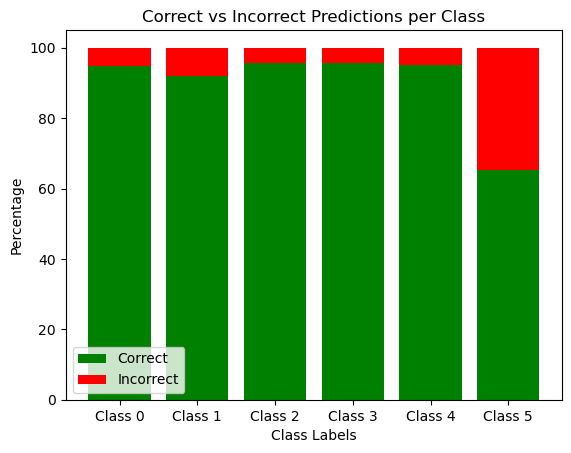

In [32]:
predictions = np.argmax(test_predictions.predictions, axis=1)  
true_labels = test_predictions.label_ids 

num_classes = len(np.unique(true_labels))
correct_counts = np.zeros(num_classes)
incorrect_counts = np.zeros(num_classes)

for i in range(len(true_labels)):
    if predictions[i] == true_labels[i]:
        correct_counts[true_labels[i]] += 1
    else:
        incorrect_counts[true_labels[i]] += 1

total_counts = correct_counts + incorrect_counts
correct_percentages = correct_counts / total_counts * 100
incorrect_percentages = incorrect_counts / total_counts * 100

labels = [f"Class {i}" for i in range(num_classes)]
x = np.arange(num_classes)

plt.bar(x, correct_percentages, label="Correct", color="green")
plt.bar(x, incorrect_percentages, bottom=correct_percentages, label="Incorrect", color="red")

plt.xlabel("Class Labels")
plt.ylabel("Percentage")
plt.title("Correct vs Incorrect Predictions per Class")
plt.xticks(x, labels)
plt.legend()
plt.show()

___
Student answers here:

Compared with the previous F1 score (about 0.927), there is a slight improvement. This shows that after dealing with the class imbalance problem through the weighted loss function, the overall performance of the model on the test set has improved.

Most categories (such as Class 0, Class 1, Class 2, and Class 3) maintain a high correct classification ratio (the green part is close to 100%).
The misclassification ratio of Class 5 (the red part) has decreased. Compared with the previous bar chart, the model's recognition ability for minority categories has improved.
___

# Task 2: Text Summarization with T5
In this task, we will use the [SamSum](https://huggingface.co/datasets/samsum) dataset, which is a collection of back-and-forth chats between people, and a narrator-style summary of the chat.
We will fine-tune our T5 model on this dataset and experiment with it on our own invented chats to see its performance.

In [12]:
import os
import numpy as np

import torch

import evaluate
from datasets import load_dataset

from transformers import (
    AutoTokenizer,
    pipeline,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    AutoModelForSeq2SeqLM,
)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
os.environ['TOKENIZERS_PARALLELISM'] = 'false' 

* Download the dataset from the Hugging Face Hub

In [3]:
samsum = load_dataset("samsum", trust_remote_code=True)

* Use Hugging Face's `pipeline` interface to see the non-finetuned performance of our model.
* Load the [T5-small](https://huggingface.co/t5-small) model inside the [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines#pipelines) object, along with the `task=summarization` attribute.
* Pick a sample from the [SamSum Test Set](https://huggingface.co/datasets/samsum/viewer/samsum/test). You can directly copy it from the website if you like.
* Input it into the created pipeline object and check the result.
    * In case of memory problems later on during fine-tuning, `del` the pipeline object to free up memory afterwards.
* Comment: How well did it work?


In [4]:
pipe = pipeline("summarization", model="t5-small", tokenizer="t5-small")

In [5]:
sample_dialogue = samsum["test"][0]["dialogue"]
print("Original Dialogue:\n", sample_dialogue)
summary = pipe(sample_dialogue)
print("\nGenerated Summary:\n", summary[0]["summary_text"])

Your max_length is set to 200, but you input_length is only 133. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


Original Dialogue:
 Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Generated Summary:
 Amanda: Lemme check Hannah: file_gif> Amanda: Sorry, can't find it . he called her last time we were at the park together Hannah: I don't know him well .


___
Student answers here:

Instead of successfully generating a concise summary, the model simply captured parts of the original conversation.
___

* Then, we will load [T5's](https://huggingface.co/t5-small) `t5-small` tokenizer, again using `AutoTokenizer` from before

In [6]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

T5 is a sequence-to-sequence encoder-decoder model, meaning that it takes sequences as input, transforms them, and outputs target sequences. The model can be used for translation, classification, summarization, and much more, given the correct input prompts.

As we are dealing with a summarization task, we need to preface our sequences with the necessary `'summarize: '` prompt.
* Write a preprocess function which takes in a dataset split and prefaces every input sequence with the string `'summarize: '`
* Afterwards, use the tokenizer with the arguments `truncation=True` and `max_length=512` to limit the maximum lengths of all inputs, and tokenize all sequences
* Then, separately transform the target sequences using `truncation=True` with a `max_length=128`
* Extract the `input_ids` from the transformed target sequences and add them to the the dictionary output of the transformed input sequences with the key `labels`
* Return the dictionary object afterwards

In [7]:
def preprocess_summarization(split):
    
    inputs = ["summarize: " + dialogue for dialogue in split["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(split["summary"], max_length=128, truncation=True, padding="max_length") 
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

* As before with the classification task, `map` the preprocessing function onto the entire dataset using the `batched=True` option

In [8]:
tokenized_samsum = samsum.map(preprocess_summarization, batched=True)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


* As the next step, we create a `collator` [object](https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq), which takes in the `tokenizer` and our `model`
    * At this stage, it is fine to just write `model='t5-small'` as input to the collator

In [9]:
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="t5-small")

* To evaluate our model's summarization performance, we employ the [ROUGE](https://huggingface.co/spaces/evaluate-metric/rouge) score.
* Advantages include:
    * The ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a metric commonly used for evaluating the quality of machine-generated text, particularly summaries
    * ROUGE measures the similarity between the generated summary and one or more reference (human-written) summaries
    * ROUGE provides a standardized way to evaluate the quality of text summaries, which is important for at-scale comparison between different summarization models
    * ROUGE includes multiple metrics, such as ROUGE-N (for n-grams), ROUGE-L (for longest common subsequence), and ROUGE-W (for weighted n-grams). Depending on the task, these metrics capture different aspects of summary quality, allowing a more comprehensive evaluation.
* Disadvantages include:
    * ROUGE relies on exact word or n-gram matches, which may not capture the semantic meaning well. Two sentences with similar meaning but slightly different phrasing might receive a low ROUGE score. (You can use the above link to play around with some references and generated sequences)
    * ROUGE does not consider the order of words or phrases. If a model generates a summary with words or phrases in a different order than the reference, even if the content is correct, the ROUGE score might be lower.
    * ROUGE measures lexical overlap and does not consider deeper linguistic structures or coherence in summaries.
* Load the `rouge` score from the `evaluate` library

In [13]:
rouge = evaluate.load("rouge")

* Then, we need to define our `compute_metrics` function, but this time for the ROUGE score
* At first, we receive again our tuple of `EvalPred` predictions and labels, which is also the input to our function
    * Split up the input tuple by extracting the labels and predictions
    * In the T5 case, the predictions are again a tuple of `(logits, hidden_representations)`
    * For our task, extract only the logits
    * Apply `argmax()` on the last dimension of the logits to get the predictions
* Then, we use our `tokenizer` to `batch_decode` the argmaxed logits
    * Here, we activate the tokenizer setting `skip_special_tokens=True`, and `clean_up_tokenization_spaces=True`
* Before we can decode our labels, we must first replace the padding tokens of the labels batch, represented by the value `-100`, with the actual padding tokens of the tokenizer
    * The `-100` are a convention of the `Seq2SeqTrainer`, and don't have any deeper meaning
    * the padding token can be accessed by `tokenizer.pad_token_id`
* Then, we also `batch_decode` the labels
    * Also skip the special tokens, but no need clean up tokenization spaces since we handled them separately
* Afterwards, we input both decoded predictions and labels into the `rouge.compute` function
* That result dictionary is returned
    * Optionally, round all numbers in the result dictionary to 4 or 6 digits, whichever format you prefer

In [14]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    result = {key: round(value, 4) for key, value in result.items()}
    
    return result

* Then we create a `Seq2SeqTrainingArguments` [instance](https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments), which is just a specialized version of our general `TrainingArguments` function from before.
* In our case, we can base our settings on the training arguments from BERT classification, except:
    * Since we now have longer sequences, it might be necessary to reduce batch sizes even more, so experiment a bit with your GPU memory availability
        * Try to max-out your GPU memory by increasing the batch size as much as possible to speed up training
    * change the `output_dir` to something under the same path from before, e.g. `'./logs/run3/'`
* Once created, load the model using the `AutoModelForSeq2SeqLM`
* Instantiate a `Seq2SeqTrainer` [object](https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/trainer#transformers.Seq2SeqTrainer) in the same style as before
    * This time, we just need to add the `collator` object to the `data_collator` argument
* Call the `train()` method and start training
* Comment briefly on the training progress

In [16]:
training_args3 = Seq2SeqTrainingArguments(
    output_dir="./logs/run3/",  
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    predict_with_generate=True,  
    evaluation_strategy="epoch",  
    save_strategy="epoch",  
    logging_dir="./logs/run3/logs",  
    logging_strategy="steps",  
    logging_steps=500,  
    save_total_limit=2,  
    num_train_epochs=3,  
    fp16=True,  
    dataloader_num_workers=2,  
    load_best_model_at_end=True,  
    metric_for_best_model="rouge1",  
    greater_is_better=True,  
    seed=42,  
)

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

trainer = Seq2SeqTrainer(
    model=model,  
    args=training_args3,  
    train_dataset=tokenized_samsum["train"],  
    eval_dataset=tokenized_samsum["validation"],  
    tokenizer=tokenizer,  
    data_collator=collator,  
    compute_metrics=compute_metrics,  
)

In [18]:
trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14732
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 11049
  Number of trainable parameters = 60506624


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.437600,0.394717,0.408300,0.183900,0.344800,0.345000
2,0.421700,0.385695,0.415700,0.192800,0.352600,0.352200
3,0.421700,0.384190,0.419500,0.194900,0.356100,0.355800


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 4
Saving model checkpoint to ./logs/run3/checkpoint-3683
Configuration saved in ./logs/run3/checkpoint-3683\config.json
Model weights saved in ./logs/run3/checkpoint-3683\pytorch_model.bin
tokenizer config file saved in ./logs/run3/checkpoint-3683\tokenizer_config.json
Special tokens file saved in ./logs/run3/checkpoint-3683\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Runn

Evaluation Results: {'eval_loss': 0.38418951630592346, 'eval_rouge1': 0.4195, 'eval_rouge2': 0.1949, 'eval_rougeL': 0.3561, 'eval_rougeLsum': 0.3558, 'eval_runtime': 336.2857, 'eval_samples_per_second': 2.432, 'eval_steps_per_second': 0.61, 'epoch': 3.0}


___
Student answers here:

Loss curve:

Training Loss and Validation Loss are gradually decreasing, indicating that the model is learning stably.
The final Training Loss and Validation Loss are 0.4217 and 0.3842 respectively.
Rouge indicators:

Rouge1, Rouge2, RougeL and Rougesum indicators are gradually increasing, indicating that the quality of the summary generated by the model is gradually improving.
In the end, Rouge1 = 0.4195, Rouge2 = 0.1949, RougeL = 0.3561, and the overall performance is good.
___

* As the last step of this exercise, move the `model`, which represents the already loaded best model due to our `Seq2SeqTrainingArguments` settings, to the CPU and input it into a new `pipeline` object as the `model=` keyword.
* Additionally, prove the `tokenizer=` argument
* Then, fill in your chosen test set sample from before
* Compare the results to your initial, pre fine-tuning output and discuss what got better or worse
* Comment on whether the narrator-style summary performance increased

In [19]:
pipe = pipeline("summarization", model=model.to("cpu"), tokenizer=tokenizer)

In [20]:
sample_dialogue = tokenized_samsum["test"][0]["dialogue"]
print("Original Dialogue:\n", sample_dialogue)

summary = pipe(sample_dialogue)
print("\nGenerated Summary:\n", summary[0]["summary_text"])

Your max_length is set to 200, but you input_length is only 133. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


Original Dialogue:
 Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Generated Summary:
 Larry called Betty last time she was at the park together. He called her last time they were there together. Hannah would rather text Betty's number.


___
Student answers here:

Before fine-tuning, the summaries generated by the model were very confusing and often simply copied snippets of conversations.
After fine-tuning, the resulting summary is more logical and focuses on the key events of the conversation (Larry and Betty's connection).
Overall, fine-tuning significantly improved the performance of the model.
___

# Inspect and share all your experiment results via TensorBoard (bonus)

* While we now only had 3 runtime variations, in practice we often have tens or hundreds of hyperparameter and/or model combinatinations
* To assemble manual train/val/test plots, scale all x- and y-axes for various units, and plot all desired combinations side by side is very cumbersome and time consuming
* Services like [tensorboard-dev](https://tensorboard.dev/) and [tensorboard in general](https://www.tensorflow.org/tensorboard) offer the possibility to simply read in our created `'logs'` directory, which enables us to browse through an online interface of automatically generated plots for all our tracked metrics
* Install (if you don't already have it) `tensorboard` via `pip install -U tensorboard)` and either:
    * Upload your `'logs'` directly to Google (requires a Google account and consent to store the specific `'logs'` directory on Google's servers)
        * execute on your command line `tensorboard dev upload --logdir logs --name "whatever-name-you-want-to-call-it"`
        * then you will need to login to your Google account, consent to uploading the `'logs'` directory, and a shareable link will appear as command line output
        * the link will lead you to the hosted experiment plots
        * FYI: it is also possible to delete uploaded tensorboards via `tensorboard dev delete --experiment_id EXPERIMENT_ID`
    * If you don't want to upload your experiments to Google or don't have a Google account, you can achieve the same browsable layout on your local machine
    * execute on your command line `tensorboard --logdir logs`
    * a localhost instance, usually on `https://localhost:6006/`, will open
* Choose one of the above options to visualize your experiments in tensorboard
* Include a screenshot of the results in the notebook submission of this exercise
    * You can embed images in Jupyerlab in markdown cells [as described here](https://stackoverflow.com/questions/41604263/how-do-i-display-local-image-in-markdown)
    * Also send us the screenshot file with it, otherwise we can't see your embedded image in the notebook
* Last note: You aren't dependend on Hugging Face experiments to upload and visualize results to tensorboard
    * You can upload every folder that is generated in the same format to tensorboard
    * For instance, the same can be achived using [PyTorch](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) and the SummaryWriter
